## Testing Models of Time Delay Function

Here, I want to test some simple analytical models, to see if my time delay function is making sense

In [53]:
# some standard python imports #
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
#lenstronomy imports
#from lenstronomy.Sampling.parameters import Param

## Simulation Cosmology Choices

In [55]:
# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.0394
z_source = 1.695

from astropy.cosmology import FlatLambdaCDM
H_0 = 70
omega_mm = 0.3
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

## Data Stuff 

In [56]:
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

# properties of the data and PSF

background_rms = .05  # background noise per pixel
exp_time = 100.  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  # cutout pixel size
deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF

kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)

data_class = ImageData(**kwargs_data)

kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
psf_class = PSF(**kwargs_psf)

## Setting up the lens model

I take a simple SIS lens with line of sight effects

In [57]:
from lenstronomy.LensModel.lens_model import LensModel

# the lens model

lens_model_list = ['POINT_MASS', 'LOS']
lens_model_base = ['POINT_MASS']

kwargs_PM = {'theta_E': 2, 'center_x': 0, 'center_y': 0}
kwargs_LOS = {
    'kappa_od': 0, 'kappa_os': 0, 'kappa_ds': 0,
    'omega_od': 0, 'omega_os': 0, 'omega_ds': 0,
    'gamma1_od': 0.1, 'gamma2_od': -0.05,
    'gamma1_os': -0.1, 'gamma2_os': 0.03,
    'gamma1_ds': -0.02, 'gamma2_ds': 0.09}
kwargs_lens = [kwargs_PM, kwargs_LOS]
kwargs_base = [kwargs_PM]

lens_model_base = LensModel(lens_model_list=lens_model_base, z_lens=z_lens, z_source=z_source, cosmo=cosmo)
lens_model_class = LensModel(lens_model_list=lens_model_list, z_lens=z_lens, z_source=z_source, cosmo=cosmo)

No line-of-sight effects being added.
Adding LOS to the main lens.


## Light Profiles


In [58]:
from lenstronomy.LightModel.light_model import LightModel

# Source model
source_model_list = ['SERSIC_ELLIPSE']
ra_source, dec_source = 0, 0
kwargs_sersic = {'amp': 1600, 'R_sersic': 0.03, 'n_sersic': 1,
                 'e1': 0.3,'e2': 0, 'center_x': 0.1, 'center_y': 0.1}
kwargs_source = [kwargs_sersic]
source_model_class = LightModel(source_model_list)
# for this example, we ignore the presence of deflector light
lens_light_model_list = []
kwargs_lens_light = []

lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

## Solving the Lens Equation

In this case, we want to identify the 2 images with the highest magnifications

In [59]:
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)



## Computing and Perturbing the Magnifications

Iin this case, because I want an exact comparison, I don't perturb the magnifications


In [60]:
# compute lensing magnification at image positions

mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
mag = np.abs(mag)  # ignore the sign of the magnification

## Setting Up the PointSource Class

In [61]:
from lenstronomy.PointSource.point_source import PointSource

point_amp = mag * 100  # multiply by intrinsic quasar brightness (in counts/s)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': point_amp}]  # quasar point source position in the lens plane and intrinsic brightness


point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

## Creating the Image

Here, I omit all the perturbations, because I want to make an exact image comparison

c:\users\daniel johnson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in log10


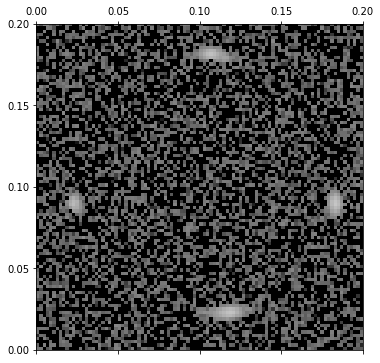

In [62]:
from lenstronomy.ImSim.image_model import ImageModel

kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 2

imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)

import lenstronomy.Util.image_util as image_util

image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
image_sim = image_sim + bkg + poisson


kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

kwargs_model = {'lens_model_list': lens_model_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 0.2, 0, 0.2])
plt.show()




## Time Delays

In what follows, I want to examine whether my time delay function produces the same results which are determined analytically 

In [63]:
#First check - ensuring that the kappas etc are inputted correctly

print("kappa_od = ", kwargs_LOS['kappa_od'])
print("kappa_od = ", kwargs_LOS['kappa_os'])
print("kappa_od = ", kwargs_LOS['kappa_ds'])
print("omega_od = ", kwargs_LOS['omega_od'])
print("omega_os = ", kwargs_LOS['omega_os'])
print("omega_ds = ", kwargs_LOS['omega_ds'])
print('')
print("gamma1_od = ", kwargs_LOS['gamma1_od'])
print("gamma2_od = ", kwargs_LOS['gamma2_od'])
print('')
print("gamma1_os = ", kwargs_LOS['gamma1_os'])
print("gamma2_os = ", kwargs_LOS['gamma2_os'])
print('')
print("gamma1_ds = ", kwargs_LOS['gamma1_ds'])
print("gamma2_ds = ", kwargs_LOS['gamma2_ds'])
print('')


kappa_od =  0
kappa_od =  0
kappa_od =  0
omega_od =  0
omega_os =  0
omega_ds =  0

gamma1_od =  0.1
gamma2_od =  -0.05

gamma1_os =  -0.1
gamma2_os =  0.03

gamma1_ds =  -0.02
gamma2_ds =  0.09



In [64]:
#next, checking that I arrive at the same distorted position
x_d, y_d = lens_model_class.lens_model.los.distort_vector(1,-1,
                                           kappa=kwargs_LOS['kappa_od'],
                                           omega=kwargs_LOS['omega_od'],
                                           gamma1=kwargs_LOS['gamma1_od'],
                                           gamma2=kwargs_LOS['gamma2_od'])

print('position at which the light leaves the lens plane = ', x_d, y_d)

position at which the light leaves the lens plane =  0.85 -1.05


In [65]:
#checking that the lensing potential is calculated correctly

psi_eff_1 = lens_model_base.potential(x_d, y_d,kwargs_base)              #evaluating the potential at the distorted position
psi_eff_2 = lens_model_class.lens_model.effective_potential(1,-1,kwargs_lens) #evaluating the effective potential from the code

print("effective potential 1 = ", psi_eff_1)
print("effective potential 2 = ", psi_eff_2)

effective potential 1 =  1.2031599740689096
effective potential 2 =  1.2031599740689096


In [66]:
#checking that the effective displacement angles are calculated correctly

#firstly, alpha at the lensed position
alpha_dist_1, alpha_dist_2 = lens_model_base.alpha(x_d, y_d, kwargs_base)
print("alpha at lensed position = ", alpha_dist_1, alpha_dist_2)

#next, alpha distorted once again by 1 - Gamma_od

a_xd, a_yd = lens_model_class.lens_model.los.distort_vector(alpha_dist_1, alpha_dist_2,
                                           kappa=kwargs_LOS['kappa_od'],
                                           omega=kwargs_LOS['omega_od'],
                                           gamma1=kwargs_LOS['gamma1_od'],
                                           gamma2=kwargs_LOS['gamma2_od'])

print("effective alpha 1 = ", a_xd, a_yd)

alph_eff_2 = lens_model_class.lens_model.effective_alpha(1,-1,kwargs_lens)

print("effective alpha 2 = ", alph_eff_2)

alpha at lensed position =  1.863013698630137 -2.3013698630136985
effective alpha 1 =  1.5616438356164386 -2.438356164383562
effective alpha 2 =  (1.5616438356164386, -2.438356164383562)


In [67]:
#checking that the displacement angle modified by Gamma_LOS is calculated correctly

a_x, a_y = lens_model_class.lens_model.los.distort_vector(alph_eff_2[0], alph_eff_2[1],
                                    kappa= - kwargs_LOS['kappa_od'] - kwargs_LOS['kappa_os'] + kwargs_LOS['kappa_ds'],
                                    omega= - kwargs_LOS['omega_od'] - kwargs_LOS['omega_os'] + kwargs_LOS['omega_ds'],
                                    gamma1= - kwargs_LOS['gamma1_od'] - kwargs_LOS['gamma1_os'] + kwargs_LOS['gamma1_ds'],
                                    gamma2=- kwargs_LOS['gamma2_od'] - kwargs_LOS['gamma2_os'] + kwargs_LOS['gamma2_ds'])

print("Gamma_LOS modified alphas = ", a_x, a_y)


Gamma_LOS modified alphas =  1.8610958904109594 -2.5613698630136987


In [68]:
#testing the Fermat Potential function itself

geometry = (a_x* alph_eff_2[0] + a_y* alph_eff_2[1]) / 2

fermat_1 = geometry - psi_eff_2

print("Fermat Potential 1 = ", fermat_1)

fermat_pot_test = lens_model_class.fermat_potential(1,-1,kwargs_lens)
print("Fermat Potential 2 = ", fermat_pot_test)

Fermat Potential 1 =  3.372790485679638
Fermat Potential 2 =  3.372790485679638
